## Deploying a Model Artifact

## Goal: 

1. Fetch an existing model from an s3 bucket,
2. Deploy as an endpoint
3. Run a few inferences

## Motivation:
I would expect models and its pre-trained weights out packaged in an archived format. It would be time consuming and expensive to retrain models over the same data, so why not pull the models and load it. This is also useful when deploying model variants to an endpoint for a/b testing.

## Approach:
Pull a model from Iris built from <a href= 'https://d-ihiviskybupf.studio.us-east-1.sagemaker.aws/jupyter/default/files/personal-learning/xgboost.ipynb?_xsrf=2%7Cda7544ab%7C6a8008a35911ebe3deecbd30672e9abb%7C1667655706'>xgboost.ipynb </a> 

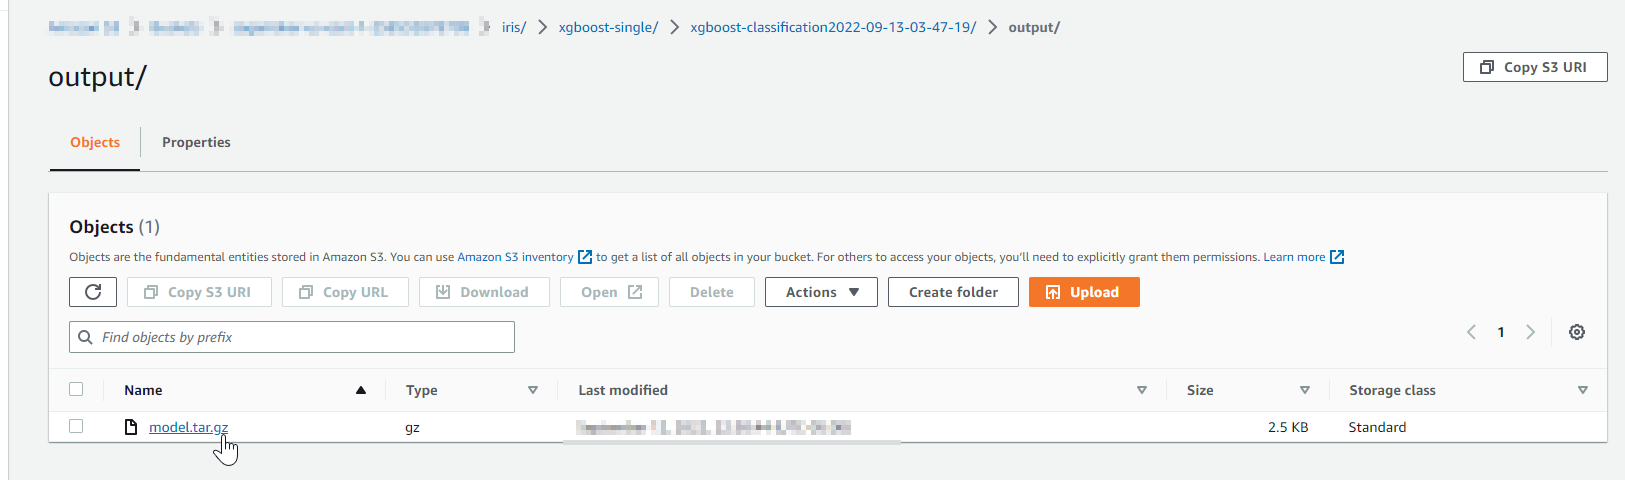

In [30]:
# load packages
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.image_uris import retrieve
from sagemaker.model import Model
from datetime import datetime
import sys
import json



In [19]:
role = get_execution_role()

region = boto3.Session().region_name

sess = sagemaker.Session()

bucket = sess.default_bucket()
prefix = 'iris'

In [20]:
model_url = f's3://{bucket}/{prefix}/xgboost-single/xgboost-classification2022-09-13-03-47-19/output/model.tar.gz'

In [21]:
container = retrieve(framework="xgboost", region=region, version="1.5-1")

model = Model(image_uri = container, 
              model_data = model_url, 
              role = role)

In [22]:
# Deploy Endpoint

endpoint_name = f"xgboost-from-artifact-{datetime.utcnow():%Y-%m-%d-%H%M}"
print("EndpointName =", endpoint_name)

model.deploy(
    initial_instance_count= 1,
    instance_type= 'ml.m4.xlarge',
    endpoint_name=endpoint_name
)

EndpointName = xgboost-from-artifact-2022-11-07-2150
-------!

# Make Inferences

In [23]:
!head -2 iris_test

1 1:6.1 2:2.8 3:4.7 4:1.2
0 1:5.4 2:3.4 3:1.5 4:0.4


In [27]:
%%time

# Single Record
runtime_client = boto3.client("runtime.sagemaker", region_name=region)


file_name = (
    "iris_test"  # customize to your test file 'mnist.single.test' if use the data above
)

with open(file_name, "r") as f:
    payload = f.read()
    single_record_payload = payload.split('\n')[0]
    

response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name, ContentType="text/x-libsvm", Body=single_record_payload
)
result = response["Body"].read().decode("ascii")
print(f"Predicted label is {result}.")

Predicted label is 1.0
.
CPU times: user 17.7 ms, sys: 0 ns, total: 17.7 ms
Wall time: 142 ms


In [31]:
## Helper functions for batch

def do_predict(data, endpoint_name, content_type):
    payload = "\n".join(data)
    response = runtime_client.invoke_endpoint(
        EndpointName=endpoint_name, ContentType=content_type, Body=payload
    )
    result = response["Body"].read().decode("ascii")
    preds = [float(num) for num in result.split("\n")[:-1]]
    return preds

def batch_predict(data, batch_size, endpoint_name, content_type):
    items = len(data)
    arrs = []
    for offset in range(0, items, batch_size):
        arrs.extend(
            do_predict(data[offset : min(offset + batch_size, items)], endpoint_name, content_type)
        )
        sys.stdout.write(".")
    return arrs


In [33]:
%%time
# run as a batch

file_name = "iris_test"
with open(file_name, "r") as f:
    payload = f.read().strip()

labels = [float(line.split(" ")[0]) for line in payload.split("\n")]
test_data = payload.split("\n")
preds = batch_predict(test_data, 5, endpoint_name, "text/x-libsvm")

print(
    "\nerror rate=%f"
    % (sum(1 for i in range(len(preds)) if preds[i] != labels[i]) / float(len(preds)))
)

......
error rate=0.033333
CPU times: user 17.7 ms, sys: 0 ns, total: 17.7 ms
Wall time: 106 ms


In [34]:
# Delete Endpoint when done
sm = boto3.Session(region_name=region).client("sagemaker")
sm.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '53337f10-baae-4394-b46d-f76c521b79ee',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '53337f10-baae-4394-b46d-f76c521b79ee',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Mon, 07 Nov 2022 22:12:41 GMT'},
  'RetryAttempts': 0}}

## References:

https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateModel.html

https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints-deployment.html#realtime-endpoints-deployment-create-model